In [1]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb

In [26]:
from mynam.models.nam import NAM as MNAM
from mynam.data.toydataset import ToyDataset
from mynam.data.generator import *
from mynam.config.default import defaults as mdefaults
from mynam.trainer.trainer import Trainer
from mynam.trainer.plotting import *

In [3]:
from nam.config import defaults
from nam.data import FoldedDataset, NAMDataset
from nam.models import NAM, get_num_units
from nam.utils import *

2023-08-01 15:06:17.789889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
%reload_ext autoreload 
%autoreload 2

In [17]:
mcfg = mdefaults()
mcfg.num_epochs=150
mcfg.hidden_sizes =[]
mcfg.activation='relu'
print(mcfg)

Config(experiment_name='nam-sparse-features-2', regression=True, use_dnn=False, num_epochs=150, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='./output', wandb=False, log_loss_frequency=10, lr=0.001, l2_regularization=0, output_regularization=0, dropout=0, feature_dropout=0, num_basis_functions=64, hidden_sizes=[], activation='relu')


In [18]:
cfg = defaults()
print(cfg)
cfg.update(**vars(mcfg))

Config(device='cpu', seed=2021, data_path='data/GALLUP.csv', experiment_name='NAM', regression=False, num_epochs=1, lr=0.0003, batch_size=1024, logdir='output', wandb=True, hidden_sizes=[64, 32], activation='exu', optimizer='adam', dropout=0.5, feature_dropout=0.5, decay_rate=0.995, l2_regularization=0.5, output_regularization=0.5, num_basis_functions=1000, units_multiplier=2, shuffle=True, cross_val=False, num_folds=5, num_splits=3, fold_num=1, num_models=1, num_workers=16, save_model_frequency=2, save_top_k=3, use_dnn=False, early_stopping_patience=50)


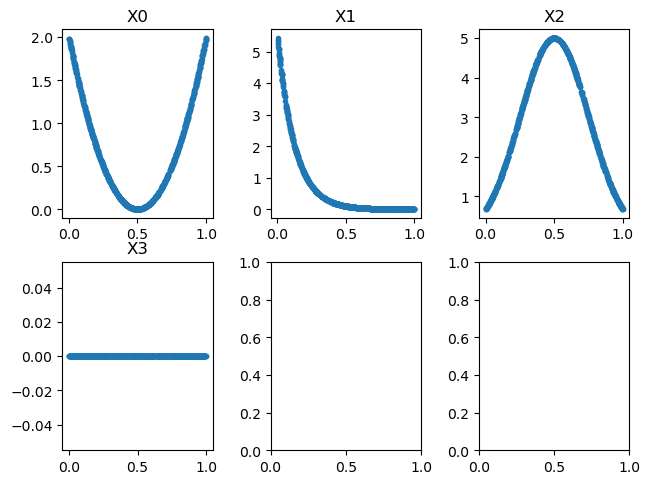

In [28]:
gen_funcs, gen_func_names = task()
sigma = 1.0
trainset = ToyDataset(gen_funcs,
                    gen_func_names, 
                      num_samples=1000, 
                     sigma=1.0)
valset = ToyDataset(gen_funcs, 
                    gen_func_names, 
                     num_samples=200)
testset = ToyDataset(gen_funcs, 
                    gen_func_names, 
                     num_samples=200, 
                    use_test=True)
in_features = trainset.in_features
trainset.plot()

In [20]:
nam = NAM(
  config=cfg,
  name="NAM",
  num_inputs=len(trainset[0][0]),
  num_units=cfg.num_basis_functions)

mnam = MNAM(
    config=mcfg, 
    name="NAM", 
    in_features=len(trainset[0][0]), 
    num_units=mcfg.num_basis_functions)

In [21]:
nam

NAM(
  (dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (dropout): Dropout(p=0, inplace=False)
      (model): ModuleList(
        (0): LinReLU(in_features=1, out_features=64)
        (1): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)

In [18]:
mnam

NAM(
  (feature_dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-7): 8 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=64)
        (1): Dropout(p=0, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0, inplace=False)
      )
    )
  )
)

In [22]:
nam_trainer = Trainer(cfg, nam, trainset, valset)
mynam_trainer= Trainer(mcfg, mnam, trainset, valset)

In [23]:
nam_lt, nam_mt, nam_lv, nam_mv = nam_trainer.train()

==============EPOCH 0================
loss_train_epoch: 21.90315055847168, MAE_train_epoch: 4.158236160874367
loss_val_epoch: 18.0347900390625, MAE_val_epoch: 3.753078579902649
==============EPOCH 10================
loss_train_epoch: 8.766240119934082, MAE_train_epoch: 2.350785255432129
loss_val_epoch: 8.626631736755371, MAE_val_epoch: 2.366173028945923
==============EPOCH 20================
loss_train_epoch: 6.5654096603393555, MAE_train_epoch: 2.026019901037216
loss_val_epoch: 5.7226338386535645, MAE_val_epoch: 1.9322161078453064
==============EPOCH 30================
loss_train_epoch: 6.397189140319824, MAE_train_epoch: 2.0029476061463356
loss_val_epoch: 5.790582180023193, MAE_val_epoch: 1.9540755450725555
==============EPOCH 40================
loss_train_epoch: 6.337224006652832, MAE_train_epoch: 2.001069590449333
loss_val_epoch: 6.138952255249023, MAE_val_epoch: 2.0214444994926453
==============EPOCH 50================
loss_train_epoch: 6.272096157073975, MAE_train_epoch: 1.989993

In [21]:
mnam_lt, mnam_mt, mnam_lv, mnam_mv = mynam_trainer.train()

==============EPOCH 0================
loss_train_epoch: 8.098565101623535, MAE_train_epoch: 2.267766296863556
loss_val_epoch: 4.660800457000732, MAE_val_epoch: 1.7182458639144897
==============EPOCH 10================
loss_train_epoch: 4.478785514831543, MAE_train_epoch: 1.7189518436789513
loss_val_epoch: 6.067419052124023, MAE_val_epoch: 2.0201475918293
==============EPOCH 20================
loss_train_epoch: 4.416563034057617, MAE_train_epoch: 1.6995189040899277
loss_val_epoch: 4.405864238739014, MAE_val_epoch: 1.6639624238014221
==============EPOCH 30================
loss_train_epoch: 4.406153202056885, MAE_train_epoch: 1.7023977860808372
loss_val_epoch: 4.49246883392334, MAE_val_epoch: 1.6936410069465637
==============EPOCH 40================
loss_train_epoch: 4.482788562774658, MAE_train_epoch: 1.7160464227199554
loss_val_epoch: 4.6605963706970215, MAE_val_epoch: 1.7493261098861694
==============EPOCH 50================
loss_train_epoch: 4.468821048736572, MAE_train_epoch: 1.71336

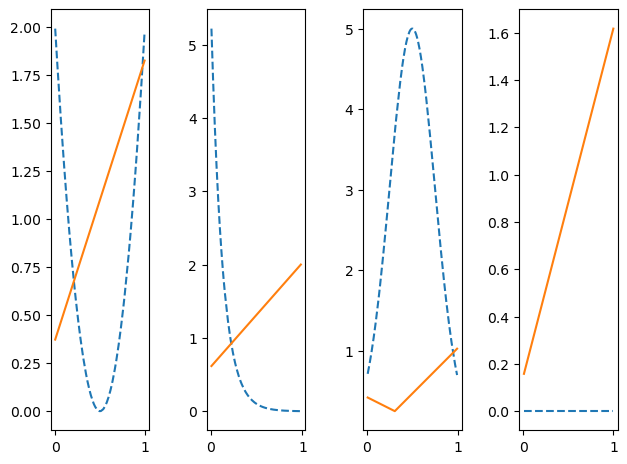

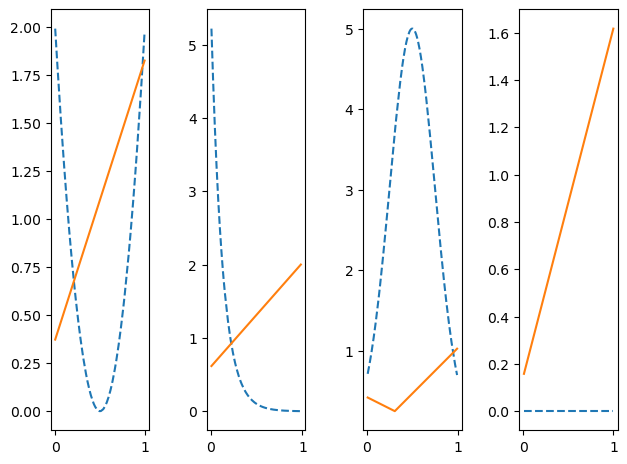

In [29]:
plot_preds(testset, nam, 150)